In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import dask.array as da
import gc
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(font_scale=2)
sns.set_style("white")

from skimage import io
import imageio
%load_ext memory_profiler
%load_ext autoreload
%autoreload 2

import os, sys
fish_path = os.path.abspath(os.path.join('..'))
if fish_path not in sys.path:
    sys.path.append(fish_path)

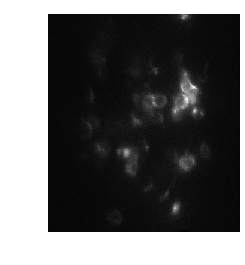

In [2]:
folderName = '/nrs/ahrens/Takashi/06152017Fish1-2'
fishName = '06152017Fish1-2'
imgFileName = 'registered.tif'
imgFile = os.path.join(folderName, imgFileName)
imgStack = io.imread(imgFile)
# check the first image
plt.imshow(imgStack[0], cmap='gray')
plt.axis('off')
plt.show()

## 1. Pixel Denoising
## 2. Motion correction

### Above is done by TK

## 3. Local pca -- spatial denoising

In [ ]:
Y = da.from_array(imgStack, chunks=(1, 4,10))
Y = Y.transpose([1,2,0])

In [ ]:
del imgStack
gc.collect()

### 3.1. Detrend raw signal on pixels

In [ ]:
import scipy
import numpy as np
import scipy.interpolate as interp
import scipy.ndimage.filters as filt



def _get_knots(stim, k=3, followup=100, spacing=250):
    # Locate transition indices
    trans_idx = np.argwhere(filt.convolve1d(stim > 0, np.array([1, -1])))
    # Repeat knots and add transition extras
    knots = np.append(np.append(np.zeros(k + 1),
                                np.sort(np.append(np.repeat(trans_idx, k),
                                                  trans_idx + followup))),
                      np.ones(k + 1) * len(stim)).astype('int')
    # add regularly spaced extra knots between transitions
    extras = np.empty(0)
    for idx in np.linspace(k + 1,
                           len(knots),
                           int(np.ceil(len(knots) / (k + 1))), dtype='int')[:-1]:
        extras = np.append(
            extras,
            np.linspace(knots[idx - 1], knots[idx],
                        int(np.round(
                            (knots[idx] - knots[idx - 1]) / spacing)) + 2,
                        dtype='int')[1:-1]
        )
    # Locate beginning/end of transition zones as knots
    return np.sort(np.append(knots, extras)).astype('int')

def _get_spline_trend(data, order=3, followup=100, spacing=200, q=.05, axis=-1, robust=True):
    """
    Fits an adaptive b-spline to an input dataset in order to remove slow
    trend and features due to application of step and ramp stimuli.
    TODO: docs
    """
    stim = np.zeros(data.shape[-1])
    knots = _get_knots(stim, k=order, followup=followup, spacing=spacing)
    x = np.arange(len(stim))

    def spline_fit(y):
        bspl = interp.make_lsq_spline(x=x, y=y, t=knots, k=order)
        return bspl(x)

    def robust_spline_fit(y):
        print(len(y))
        bspl = interp.make_lsq_spline(x=x, y=y, t=knots, k=order)
        resid = np.abs(bspl(x) - y)
        keep_idx = resid <= np.percentile(resid, (1 - q) * 100)
        bspl = interp.make_lsq_spline(
            x=x[keep_idx], y=y[keep_idx], t=knots, k=order)
        return bspl(x)
    
    # fit spline To whole dataset
    if robust:
        trend = da.apply_along_axis(robust_spline_fit, axis, data).compute()
    else:
        trend = da.apply_along_axis(spline_fit, axis, data).compute()
    return trend


def detrend(mov, order=3, followup=100, spacing=200, q=.05, axis=-1, robust=True):
    # Adaptive spline fit
    trend = _get_spline_trend(data=mov,
                              order=order,
                              followup=followup,
                              spacing=spacing,
                              q=q,
                              axis=axis,
                              robust=robust)
    mov_detr = mov - trend
    return mov_detr, trend

In [ ]:
Y_detr, trend, _, _ = detrend(Y) # this could be speed up using mp....
# np.save('tmpData/%s_Y_detr'%(fishName), Y_detr)
# np.save('tmpData/%s_Y_trend'%(fishName), trend)

In [ ]:
Y[:, :, 0].compute()

In [ ]:
Y.mean(axis=-1).shape

In [ ]:
plt.plot(Y[150, 150, :])

## 4. Demix